# inicializacao

In [1]:
import numpy as np
import pandas as pd
import sympy as sp
import scipy.io as sc 
import scipy.signal as signal
from sympy import symbols, pprint
import matplotlib.pyplot as plt
from structureSelector import *

from methods.utils.utilities import *
import plotly.express as px

def metrics(y, yest):
    residuo1 = y - yest
    mape = round(np.mean(np.abs(residuo1 / (yest + np.finfo(np.float64).eps))), 5)
    print('RMSE:', f'{np.sqrt(np.mean(np.square(residuo1))):.2e}' , 'MSE:', f'{np.mean(np.square(residuo1)):.2e}' , '\nAET:', np.sum(np.abs(residuo1)), '\nMAPE:', str(mape) + '%')

def integrate(p, ts=0.1):
    r = np.zeros(p.shape)
    r[0] = p[0] * ts
    for i in range(1, p.shape[0]):
        r[i] = r[i-1] + p[i] * ts
    return r


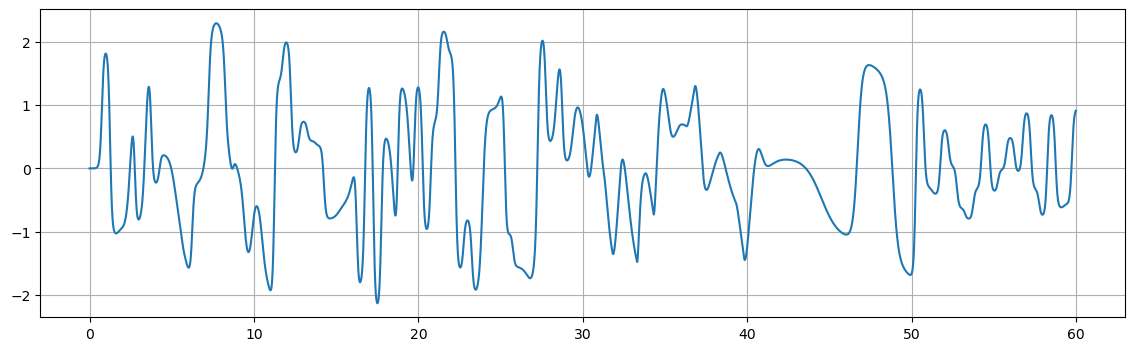

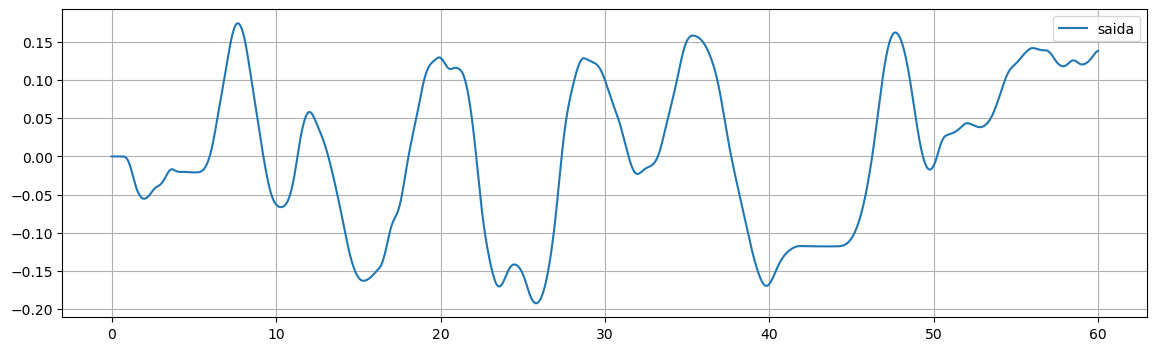

In [2]:
#my_data = np.genfromtxt('data/ballBeamTeste1.csv', delimiter=',')[1:,:]
my_data = np.genfromtxt('data/ballBeamFriction.csv', delimiter=',')[1:,:]
u = my_data[:, 0].copy()
y = my_data[:, 1].copy() 
t = my_data[:, -1].copy()

np.random.seed(15)
amplitude = 0.00001
#u += np.random.uniform(-0.0002, 0.0002, u.shape)
#y = y + np.random.uniform(-amplitude, amplitude, y.shape)

dt = my_data[1, -1]
size = 6000
plt.figure(figsize=(14, 4))
plt.plot(t, u*(180/np.pi), label="entrada")
plt.grid()
plt.show()
plt.figure(figsize=(14, 4))
plt.plot(t[:size], y[:size], label="saida")
plt.legend()
plt.grid()
plt.show()

# Estimacao

[Y1.1 cos(U1.2)*sign(Y1.1) U1.8*cos(Y1.1) Y1.8*cos(U1.5) Y1.2 U1.4 Y1.3
 Y1.4] [ 7.92788109e-01 -1.50013582e-04  4.88571097e-02 -3.40404667e-02
  4.04978019e-01 -9.91917704e-02 -9.62669771e-02 -6.74587014e-02] [1, 295, 218, 205, 2, 16, 3, 4]

Um passo a frente
RMSE: 7.90e-05 MSE: 6.24e-09 
AET: 0.35366417612275186 
MAPE: 0.15291%

Simulação livre
RMSE: 7.64e-04 MSE: 5.83e-07 
AET: 3.368591499583175 
MAPE: 1.36749%
-0.0991917703555167*U1.4 + 0.0488571096896032*U1.8*cos(Y1.1) + 0.792788108618942*Y1.1 + 0.404978018533818*Y1.2 - 0.0962669771028004*Y1.3 - 0.0674587013573986*Y1.4 - 0.0340404667317299*Y1.8*cos(U1.5) - 0.000150013582271597*cos(U1.2)*sign(Y1.1)


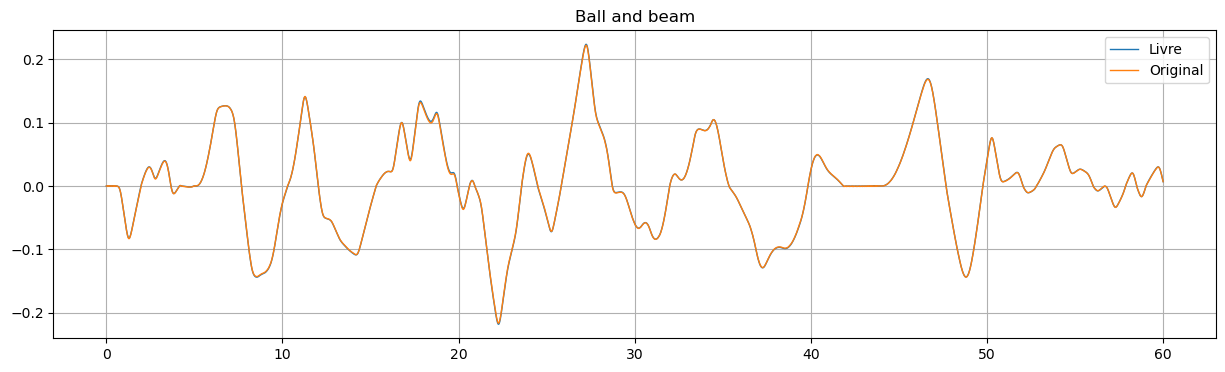

'\nUm passo a frente\nRMSE: 7.900448218727423e-05 MSE: 6.241708205679332e-09 \nAET: 0.35366417612275186 \nMAPE: 0.15291%\n\nSimulação livre\nRMSE: 0.0007637376662686488 MSE: 5.83295222877482e-07 \nAET: 3.368591499583175 \nMAPE: 1.36749%\n'

In [3]:
ui = np.reshape(u, (1, -1)).copy()
yi = np.reshape(y, (1, -1)).copy()

'''
amplitude = 0.000001
yi = yi + np.random.uniform(-amplitude, amplitude, yi.shape)
mean_gaussian = 0
std_gaussian = 0.000005
noise_gaussian = np.random.normal(mean_gaussian, std_gaussian, yi.shape)
yi += noise_gaussian'''

yi[0,1:] = (yi[0,1:] - yi[0,:-1]) / dt

output = 0  
num = [10]
params = []
params.append({'nb':[8],'na':[8], 'level':2, 'nonlinear':[0,5,0,0,1, 0,0,0,0,0], 'root':False, 'delay':2, 'diff':False, 'ymodifier':[0,0]})

sselector = structureSelector()
clip.setLimit(-0.2, 0.2)
ss = sselector.symbolic_regressors(**params[output], intg=False)

vCandidatos = sselector.matrix_candidate(ui, yi, **params[output], dt=dt, intg=False)

pad = max(max(params[output]['nb']), max(params[output]['na']))
aux = max(params[output]['nonlinear'])
pad = max(pad, aux)
psi, selected  = sselector.semp(vCandidatos.T, yi[output, pad:], num[output], 1e-13)

model = ss[selected]

theta = LSM(yi[output, pad:], psi)
print(model, theta, selected)

model = ss[selected]

yhat = sselector.oneStepForward2(u=ui, y=yi, theta=theta, selected=selected, nb=params[output]['nb'], na=params[output]['na'], level=params[output]['level'], index=output, root=params[output]['root'], delay=params[output]['delay'], diff=params[output]['diff'], dt=dt, intg=False, nonlinear=params[output]['nonlinear'], ymodifier=params[output]['ymodifier'])
print("\nUm passo a frente")
metrics(yi, yhat)

slivre = sselector.predict(ui, yi, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=dt, intg=False)
print("\nSimulação livre")
metrics(yi, slivre)

print(model @ theta)
l = 1
plt.figure(figsize=(15,4));plt.title("Ball and beam")
plt.plot(t, slivre, label='Livre', linewidth=l);#plt.ylim(-0.2,0.2);
plt.plot(t, yi.T, label='Original', linewidth=l);plt.legend();plt.grid();plt.show()

'''
Um passo a frente
RMSE: 7.900448218727423e-05 MSE: 6.241708205679332e-09 
AET: 0.35366417612275186 
MAPE: 0.15291%

Simulação livre
RMSE: 0.0007637376662686488 MSE: 5.83295222877482e-07 
AET: 3.368591499583175 
MAPE: 1.36749%
'''


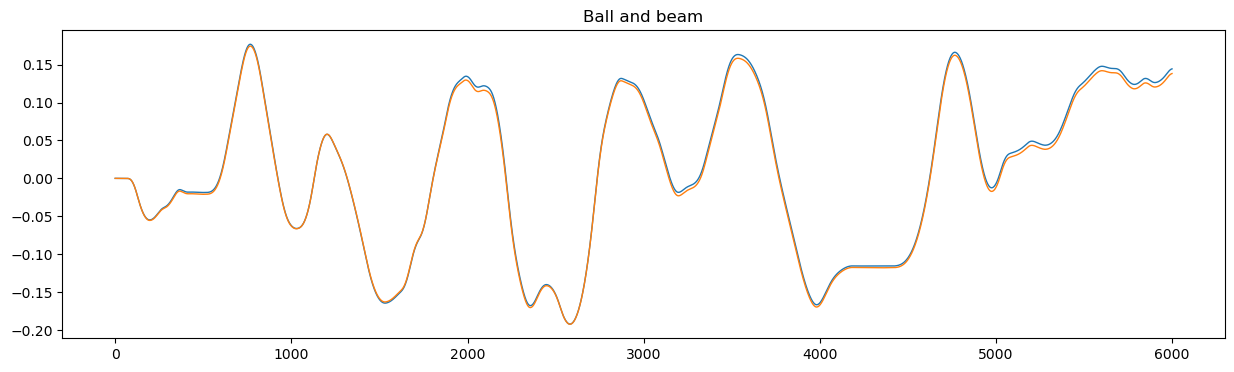

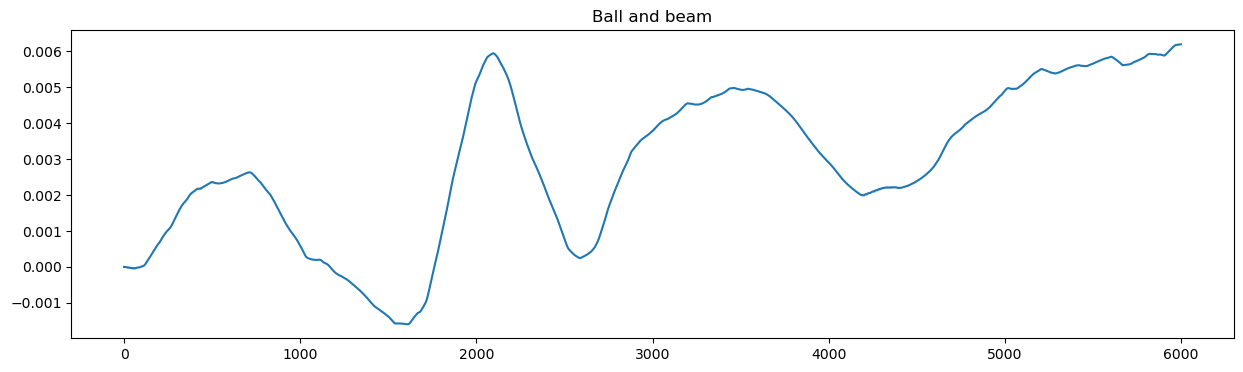

In [19]:
Y = integrate(slivre, dt)
l = 1
plt.figure(figsize=(15,4));plt.title("Ball and beam")
#plt.plot((y[1:]-y[:-1])/dt)
plt.plot(Y, linewidth=l)
plt.plot(y, linewidth=l)
plt.show()
plt.figure(figsize=(15,4));plt.title("Ball and beam")
plt.plot(Y - y)
#plt.plot(noise_gaussian.T)
plt.show()

## imagens

In [20]:
'''data = np.vstack((ui, yi, t)).T
#print(un.shape, s.shape, data.shape)
np.savetxt("data/ballBeamNoise.csv", data, delimiter=",", fmt="%.6f", header="input,output,time", comments="")'''

'data = np.vstack((ui, yi, t)).T\n#print(un.shape, s.shape, data.shape)\nnp.savetxt("data/ballBeamNoise.csv", data, delimiter=",", fmt="%.6f", header="input,output,time", comments="")'

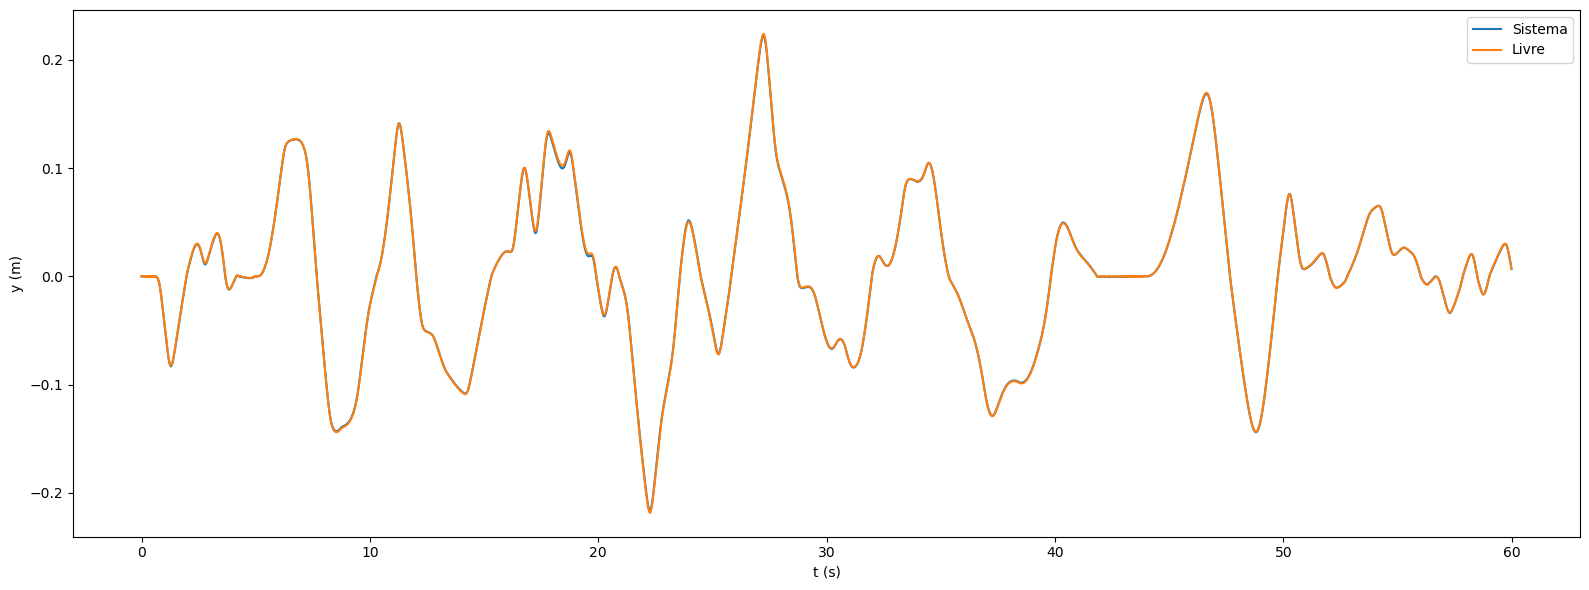

In [21]:
l = 1.5
plt.figure(figsize=(16, 6))
plt.plot(t, yi[output].T, label='Sistema', linewidth=l)
plt.plot(t, slivre, label='Livre', linewidth=l)
#plt.ylim((-0.2, 0.2))

plt.ylabel('y (m)')
plt.xlabel('t (s)')
plt.legend()
plt.tight_layout() 
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Jonh - TCC/figuras/ballBeamEst.png')

plt.show()

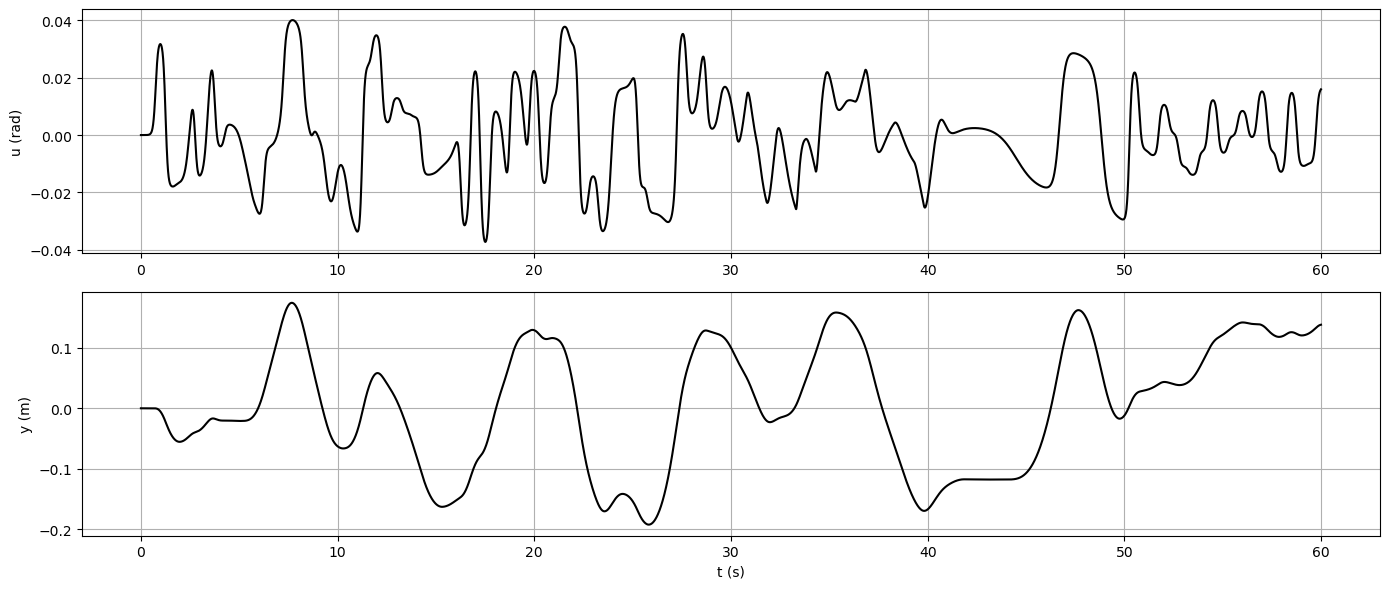

In [22]:
f, ax = plt.subplots(2, 1, figsize=[14, 6])
ax[0].plot(t, ui[0].T, label='Entrada', color='black')
ax[0].set_ylabel('u (rad)')

ax[1].plot(t, y, label='Saída', color='black')
ax[1].set_ylabel('y (m)')
ax[1].set_xlabel('t (s)')


plt.tight_layout() 
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Jonh - TCC/figuras/ballandbeamEst.png')
ax[0].grid()
ax[1].grid()
plt.show()

# Validacao

## preparação

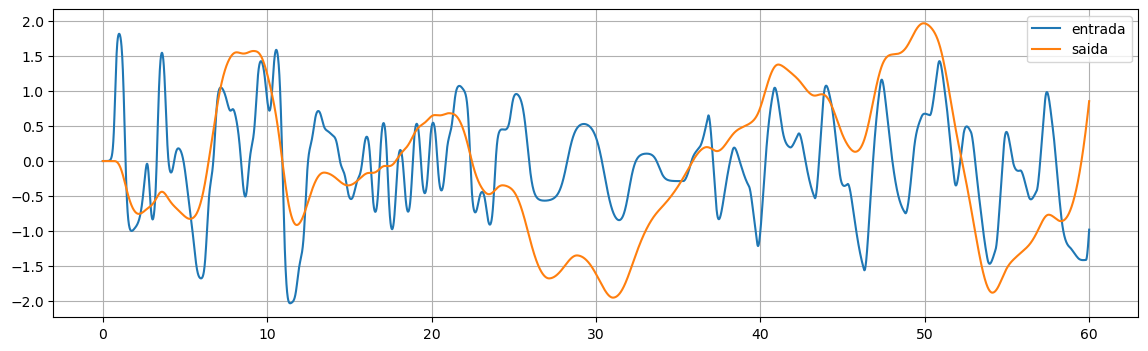

In [4]:

val_data = np.genfromtxt('data/ballBeamFrictionVal.csv', delimiter=',')[1:,:]

uVal = np.reshape(val_data[:, 0], (1, -1))
yVal = np.reshape(val_data[:, 1], (1, -1))
#yVal = yVal + np.random.uniform(-amplitude, amplitude, yVal.shape)

tVal = val_data[:, -1]
dt = val_data[1, -1]

plt.figure(figsize=(14, 4))
plt.plot(tVal, uVal.T*(180/np.pi), label="entrada")
plt.plot(tVal, yVal.T*10, label="saida")

plt.legend();plt.grid();plt.show()

## simul


Um passo a frente
RMSE: 7.09e-05 MSE: 5.02e-09 
AET: 0.33188501668656967 
MAPE: 0.04572%

Simulação livre
RMSE: 5.62e-04 MSE: 3.16e-07 
AET: 2.72129290735994 
MAPE: 0.12251%


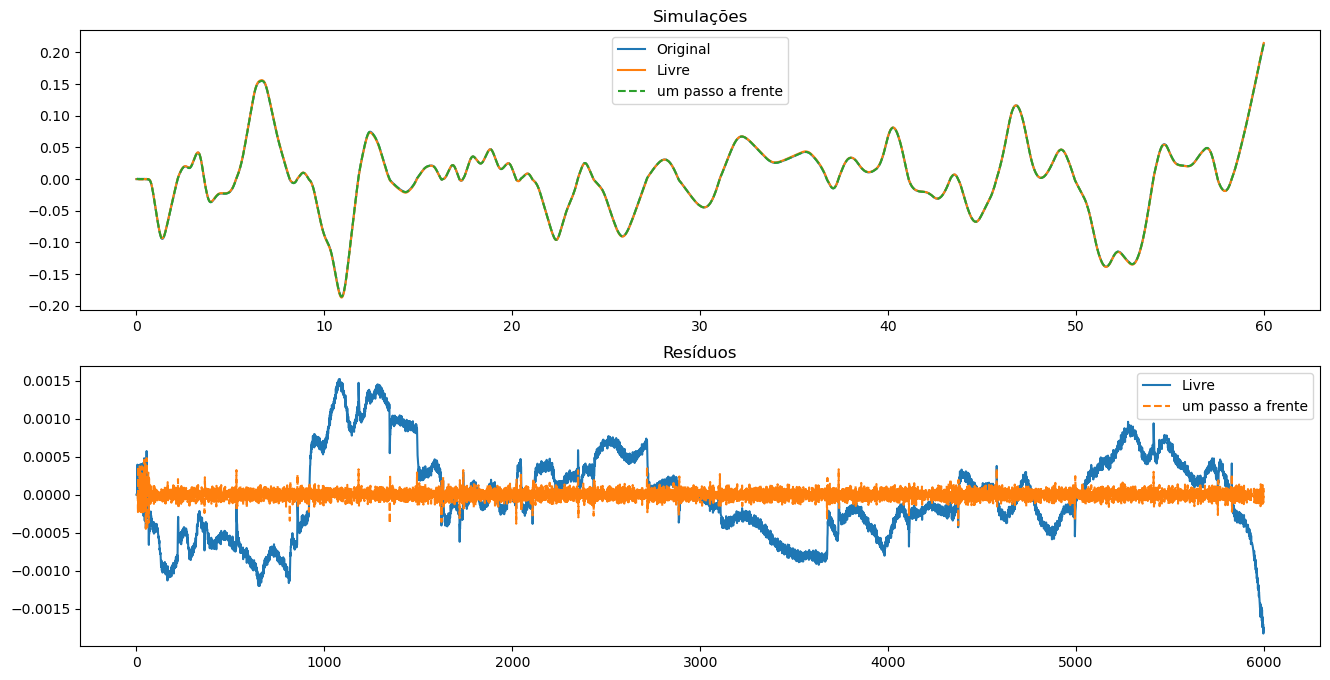

' \n\nUm passo a frente\nRMSE: 7.09e-05 MSE: 5.02e-09 \nAET: 0.33188501668656967 \nMAPE: 0.04572%\n\nSimulação livre\nRMSE: 5.62e-04 MSE: 3.16e-07 \nAET: 2.72129290735994 \nMAPE: 0.12251%\n\n'

In [5]:
dyVal = np.zeros(yVal.shape)
dyVal[output, 1:] = (yVal[output, 1:] - yVal[output, :-1]) / dt
valCandidatos = sselector.matrix_candidate(uVal, dyVal, **params[output], dt=dt, intg=False)

hatVal = sselector.oneStepForward2(u=uVal, y=dyVal, theta=theta, selected=selected, nb=params[output]['nb'], na=params[output]['na'], level=params[output]['level'], index=output, root=params[output]['root'], delay=params[output]['delay'], diff=params[output]['diff'], dt=dt, intg=False, nonlinear=params[output]['nonlinear'], ymodifier=params[output]['ymodifier'])
print("\nUm passo a frente")
metrics(dyVal, hatVal)

'''
vPsi = valCandidatos[selected, :]
hatVal = np.zeros(yVal.shape[1])
hatVal[:pad] = yVal[output, :pad]
hatVal[pad:] = vPsi.T @ theta
print("\nUm passo a frente")
metrics(yVal, hatVal)

hatVal = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], dt=0.1)
print("\nUm passo a frente")
metrics(yVal, hatVal)
'''

valLivre = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1)
print("\nSimulação livre")
metrics(dyVal, valLivre)

f, ax = plt.subplots(2,1, figsize=[16,8])

ax[0].plot(tVal, dyVal.T, label='Original')
ax[0].plot(tVal, valLivre, label='Livre')
ax[0].plot(tVal, hatVal, '--', label='um passo a frente')
ax[0].set_title("Simulações");ax[0].legend()


ax[1].plot(dyVal[output].T - valLivre, label='Livre')
ax[1].plot(dyVal[output].T - hatVal, '--', label='um passo a frente')
ax[1].set_title("Resíduos");ax[1].legend()
plt.show()
''' 

Um passo a frente
RMSE: 7.09e-05 MSE: 5.02e-09 
AET: 0.33188501668656967 
MAPE: 0.04572%

Simulação livre
RMSE: 5.62e-04 MSE: 3.16e-07 
AET: 2.72129290735994 
MAPE: 0.12251%

'''

## arquivo

In [13]:
'''data = np.vstack((uVal, yVal, tVal)).T
#print(un.shape, s.shape, data.shape)
np.savetxt("data/ballBeamDataVal.csv", data, delimiter=",", fmt="%.6f", header="input,output,time", comments="")'''

'data = np.vstack((uVal, yVal, tVal)).T\n#print(un.shape, s.shape, data.shape)\nnp.savetxt("data/ballBeamDataVal.csv", data, delimiter=",", fmt="%.6f", header="input,output,time", comments="")'

[Y1.1 cos(U1.2)*sign(Y1.1) U1.8*cos(Y1.1) Y1.8*cos(U1.5) Y1.2 U1.4 Y1.3
 Y1.4]


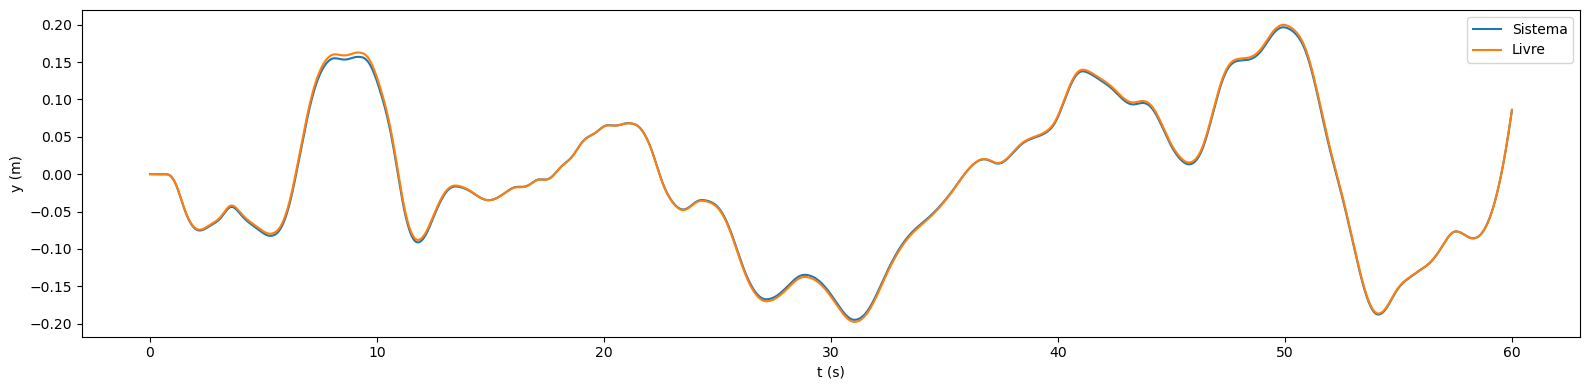

In [14]:
l = 1.5
print(model)
plt.figure(figsize=(16, 4))
plt.plot(tVal, yVal[output].T, label='Sistema', linewidth=l)
plt.plot(tVal, integrate(valLivre, dt), label='Livre', linewidth=l)
#plt.ylim((-0.2, 0.2))

plt.ylabel('y (m)')
plt.xlabel('t (s)')
plt.legend()
plt.tight_layout() 
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Jonh - TCC/figuras/ballBeamVal.png')

plt.show()

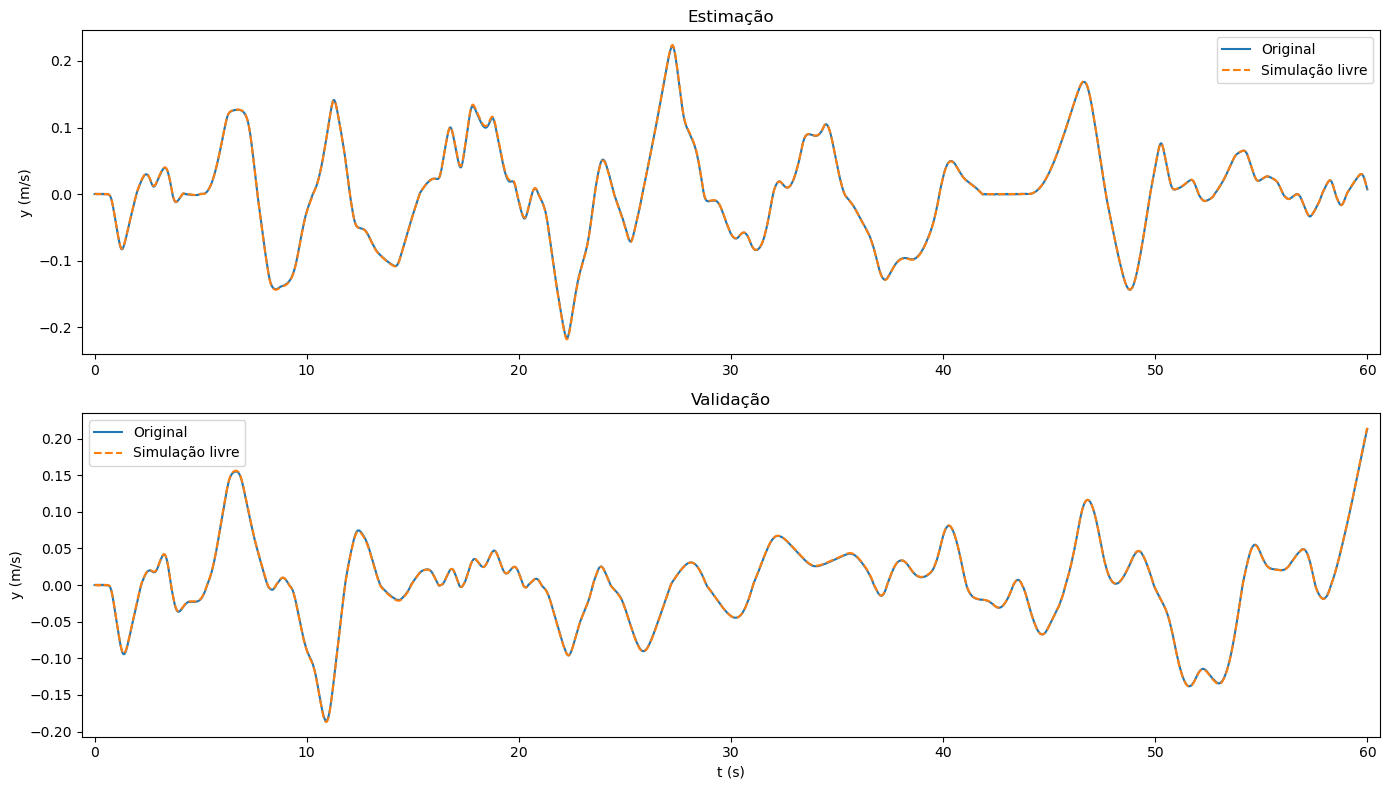

In [21]:

f, ax = plt.subplots(2, 1, figsize=[14, 8])
ax[0].plot(t, yi[output], label='Original')
ax[0].plot(t, slivre, '--', label='Simulação livre')
ax[0].set_ylabel('y (m/s)')
ax[0].set_title("Estimação")
ax[0].legend()

ax[1].plot(t, dyVal[output], label='Original')
ax[1].plot(t, valLivre, '--', label='Simulação livre')
ax[1].set_ylabel('y (m/s)')
ax[1].set_xlabel('t (s)')
ax[1].set_title("Validação")
ax[1].legend()

ax[0].margins(x=0.01)
ax[1].margins(x=0.01)

plt.tight_layout() 
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Jonh - TCC/figuras/ballBeamResult.png')

plt.show()

# Residuo

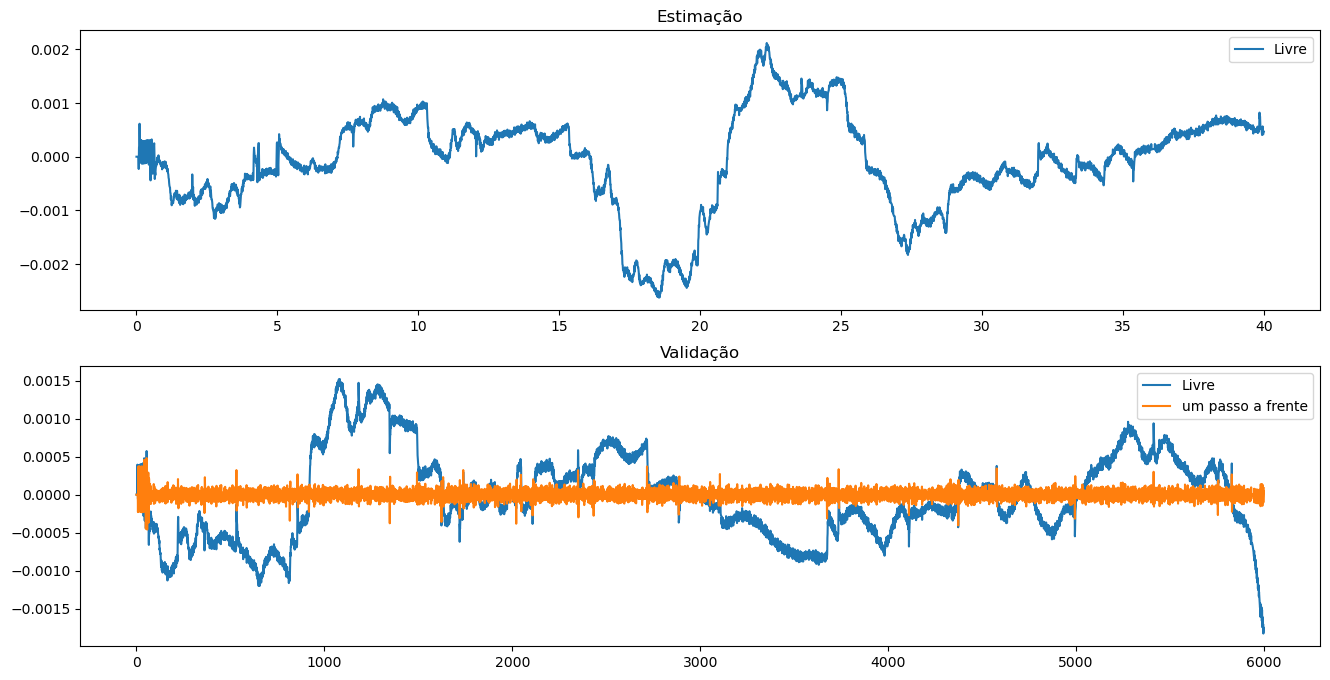

In [13]:
f, ax = plt.subplots(2,1, figsize=[16,8])

ax[0].plot(t[:4000], yi[output, :4000].T - slivre[:4000], label='Livre')
#ax[0].plot(t[:4000], yi[output, :4000].T - yhat[:4000], label='um passo a frente')
ax[0].set_title("Estimação");ax[0].legend()


ax[1].plot(dyVal[output].T - valLivre, label='Livre')
ax[1].plot((dyVal[output].T - hatVal)[:], label='um passo a frente')
ax[1].set_title("Validação");ax[1].legend()
plt.show()

# Simple Narx

[Y1.1 U1.2 U1.7 Y1.6 Y1.1**3 U1.2*Y1.1**2 Y1.1**2*Y1.2] [  1.16838685  -0.04291435   0.03349998  -0.16927943 -27.96489358
  -1.90190701  27.9662116 ] [1, 7, 12, 6, 91, 97, 92]

Simulação livre
RMSE: 4.86e-03 MSE: 2.36e-05 
AET: 23.06394877284693 
MAPE: 1.53783%

Um passo a frente
RMSE: 9.35e-05 MSE: 8.74e-09 
AET: 0.4250562000680569 
MAPE: 0.93069%


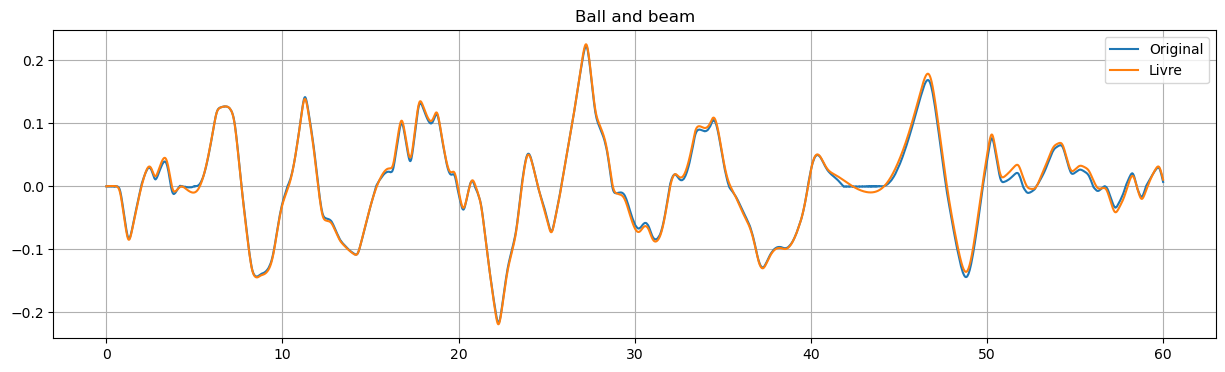

'\nSimulação livre\nRMSE: 4.86e-03 MSE: 2.36e-05 \nAET: 23.06394877284693 \nMAPE: 1.53783%\n\nUm passo a frente\nRMSE: 9.35e-05 MSE: 8.74e-09 \nAET: 0.4250562000680569 \nMAPE: 0.93069%\n'

In [10]:

output = 0  
num = [10]
params = []
params.append({'nb':[6],'na':[7], 'level':3, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':1, 'diff':False, 'ymodifier':[0,0]})

sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output], intg=False)
#print(ss)
vCandidatos = sselector.matrix_candidate(ui, yi, **params[output], dt=dt, intg=False)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, yi[output, pad:], num[output], 1e-13)

model = ss[selected]

theta = LSM(yi[output, pad:], psi)
print(model, theta, selected)

model = ss[selected]

polinomial_slivre = sselector.predict(ui, yi, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=dt, intg=False)
print("\nSimulação livre")
metrics(yi, polinomial_slivre)
'''
yhat = sselector.oneStepForward(ui, yi, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['diff'], dt=dt, intg=False)
print("\nUm passo a frente")
metrics(yi, yhat)
'''
yhat = sselector.oneStepForward2(u=ui, y=yi, theta=theta, selected=selected, nb=params[output]['nb'], na=params[output]['na'], level=params[output]['level'], index=output, root=params[output]['root'], delay=params[output]['delay'], diff=params[output]['diff'], dt=dt, intg=False, nonlinear=params[output]['nonlinear'], ymodifier=params[output]['ymodifier'])
print("\nUm passo a frente")
metrics(yi, yhat)

plt.figure(figsize=(15,4));plt.title("Ball and beam")
plt.plot(t, yi.T, label='Original');plt.plot(t, polinomial_slivre, label='Livre')
plt.legend();plt.grid();plt.show()
'''
Simulação livre
RMSE: 4.86e-03 MSE: 2.36e-05 
AET: 23.06394877284693 
MAPE: 1.53783%

Um passo a frente
RMSE: 9.35e-05 MSE: 8.74e-09 
AET: 0.4250562000680569 
MAPE: 0.93069%
'''

In [15]:
print(model @ theta)


-1.90190701232935*U1.2*Y1.1**2 - 0.0429143495567611*U1.2 + 0.0334999806559845*U1.7 - 27.964893583819*Y1.1**3 + 27.9662116003437*Y1.1**2*Y1.2 + 1.16838684698592*Y1.1 - 0.169279429068078*Y1.6


NameError: name 'Y' is not defined

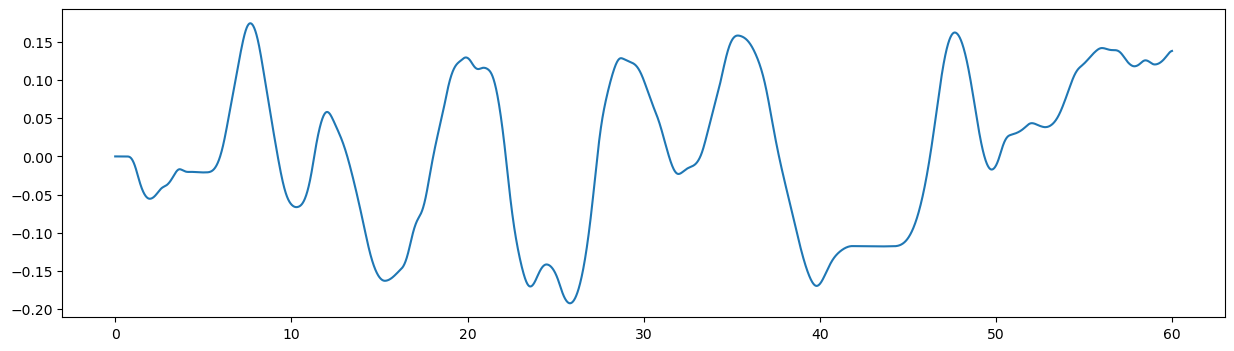

In [17]:
YV = integrate(polinomial_slivre, dt)
plt.figure(figsize=(15,4))
plt.plot(t, y, label='Original')
plt.plot(t, Y,'--', label='Proposto')
plt.plot(t, YV,'--', label='Polinomial')
plt.xlabel('t (s)')
plt.ylabel('y (m)')
plt.tight_layout() 
plt.legend()
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Jonh - TCC/figuras/ballBeamI.png')
plt.show()


Simulação livre
RMSE: 5.14e-03 MSE: 2.64e-05 
AET: 23.97416973748132 
MAPE: 0.57695%

Um passo a frente
RMSE: 8.78e-05 MSE: 7.71e-09 
AET: 0.4065299280286838 
MAPE: 0.82655%


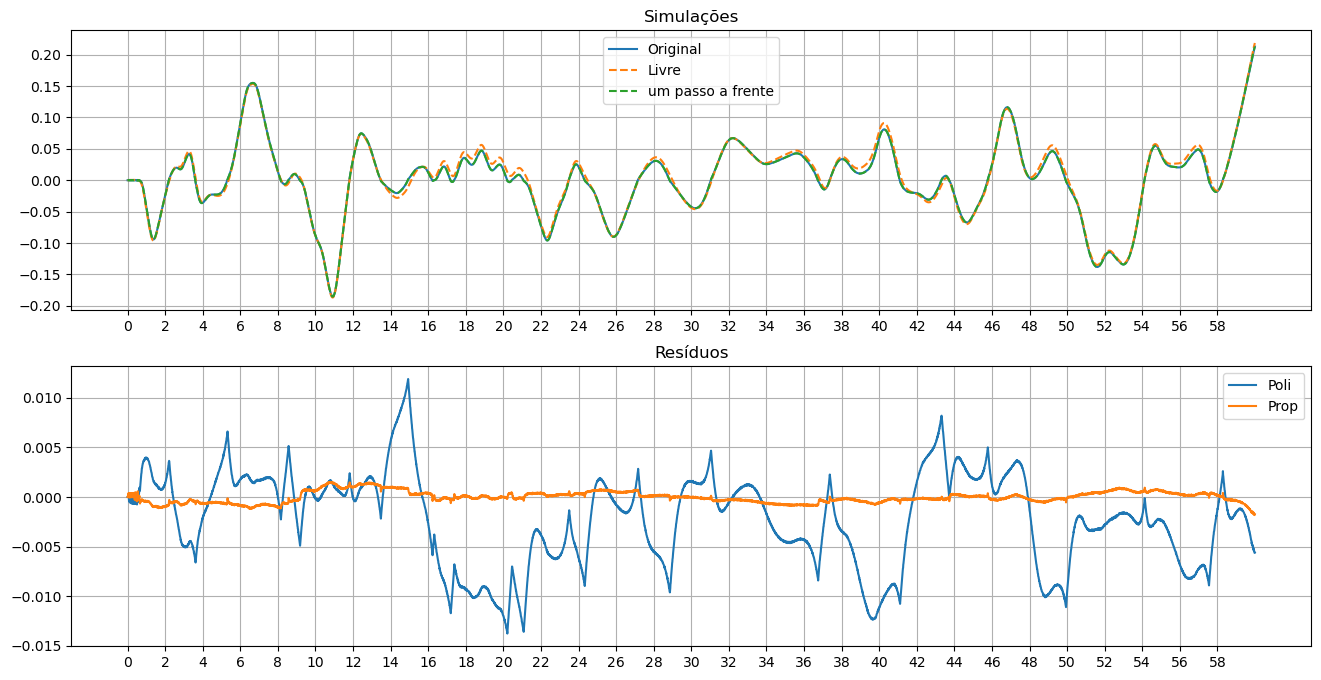

'\nSimulação livre\nRMSE: 5.16e-03 MSE: 2.66e-05 \nAET: 23.73781078017715 \nMAPE: 0.93548%\n\nUm passo a frente\nRMSE: 8.79e-05 MSE: 7.73e-09 \nAET: 0.40729880036984023 \nMAPE: 0.69444%\n'

In [11]:
polinomial_valLivre = sselector.predict(uVal, dyVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1)

print("\nSimulação livre")
metrics(dyVal, polinomial_valLivre)

hatVal = sselector.oneStepForward2(u=uVal, y=dyVal, theta=theta, selected=selected, nb=params[output]['nb'], na=params[output]['na'], level=params[output]['level'], index=output, root=params[output]['root'], delay=params[output]['delay'], diff=params[output]['diff'], dt=dt, intg=False, nonlinear=params[output]['nonlinear'], ymodifier=params[output]['ymodifier'])
print("\nUm passo a frente")
metrics(dyVal, hatVal)

f, ax = plt.subplots(2,1, figsize=[16,8])
end = 6000
ax[0].plot(tVal[ :end], dyVal[output, :end].T, label='Original')
ax[0].plot(tVal[ :end], polinomial_valLivre[ :end], '--', label='Livre')
ax[0].plot(tVal[ :end], hatVal[ :end], '--', label='um passo a frente')
ax[0].set_title("Simulações");ax[0].legend()
ax[0].grid()
ax[0].set_xticks(tVal[::200])

ax[1].plot(tVal, dyVal[output].T - polinomial_valLivre, label='Poli')
ax[1].plot(tVal, dyVal[output].T - valLivre, label='Prop')
ax[1].set_title("Resíduos");ax[1].legend()
ax[1].grid()
ax[1].set_xticks(tVal[::200])
plt.show()

'''
Simulação livre
RMSE: 5.16e-03 MSE: 2.66e-05 
AET: 23.73781078017715 
MAPE: 0.93548%

Um passo a frente
RMSE: 8.79e-05 MSE: 7.73e-09 
AET: 0.40729880036984023 
MAPE: 0.69444%
'''

# Comparativo

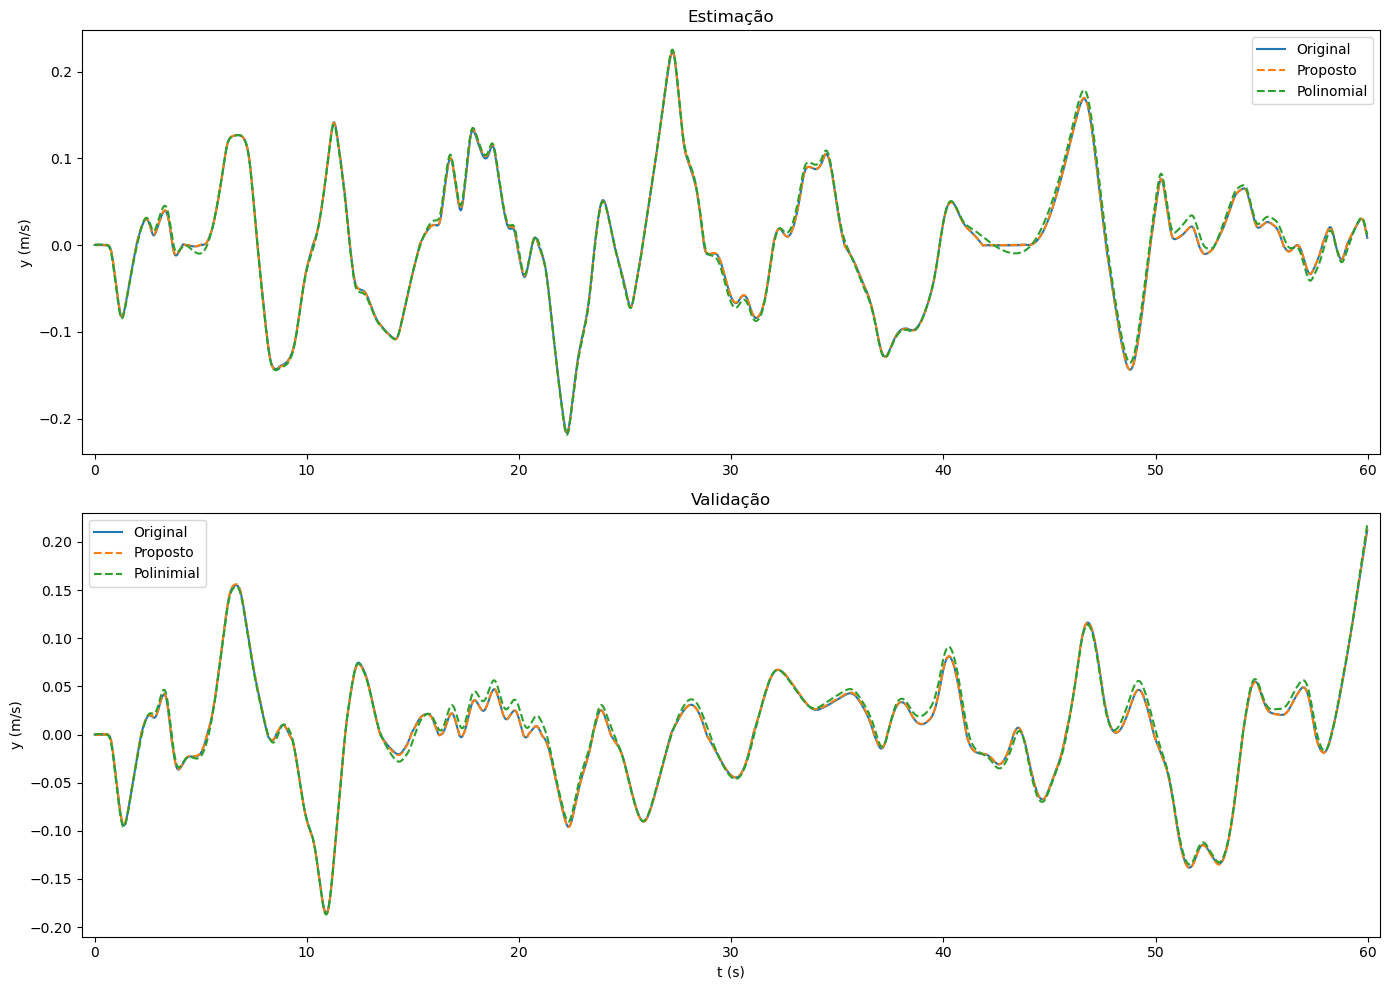

In [18]:
begin = 0
end = -1
f, ax = plt.subplots(2, 1, figsize=[14, 10])
ax[0].plot(t[begin: end], yi.T[begin: end], label='Original')
ax[0].plot(t[begin: end], slivre[begin: end], '--', label='Proposto')
ax[0].plot(t[begin: end], polinomial_slivre[begin: end], '--', label='Polinomial')

ax[0].set_ylabel('y (m/s)')

ax[0].set_title("Estimação")
ax[0].legend()

ax[1].plot(t[begin: end], dyVal.T[begin: end], label='Original')
ax[1].plot(t[begin: end], valLivre[begin: end], '--', label='Proposto')
ax[1].plot(t[begin: end], polinomial_valLivre[begin: end], '--', label='Polinimial')
ax[1].set_ylabel('y (m/s)')
ax[1].set_xlabel('t (s)')
ax[1].set_ylim(-0.21, 0.23)
ax[1].set_title("Validação")
ax[1].legend()

ax[0].margins(x=0.01)
ax[1].margins(x=0.01)

plt.tight_layout() 
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Jonh - TCC/figuras/ballBeamComparate.png')

plt.show()

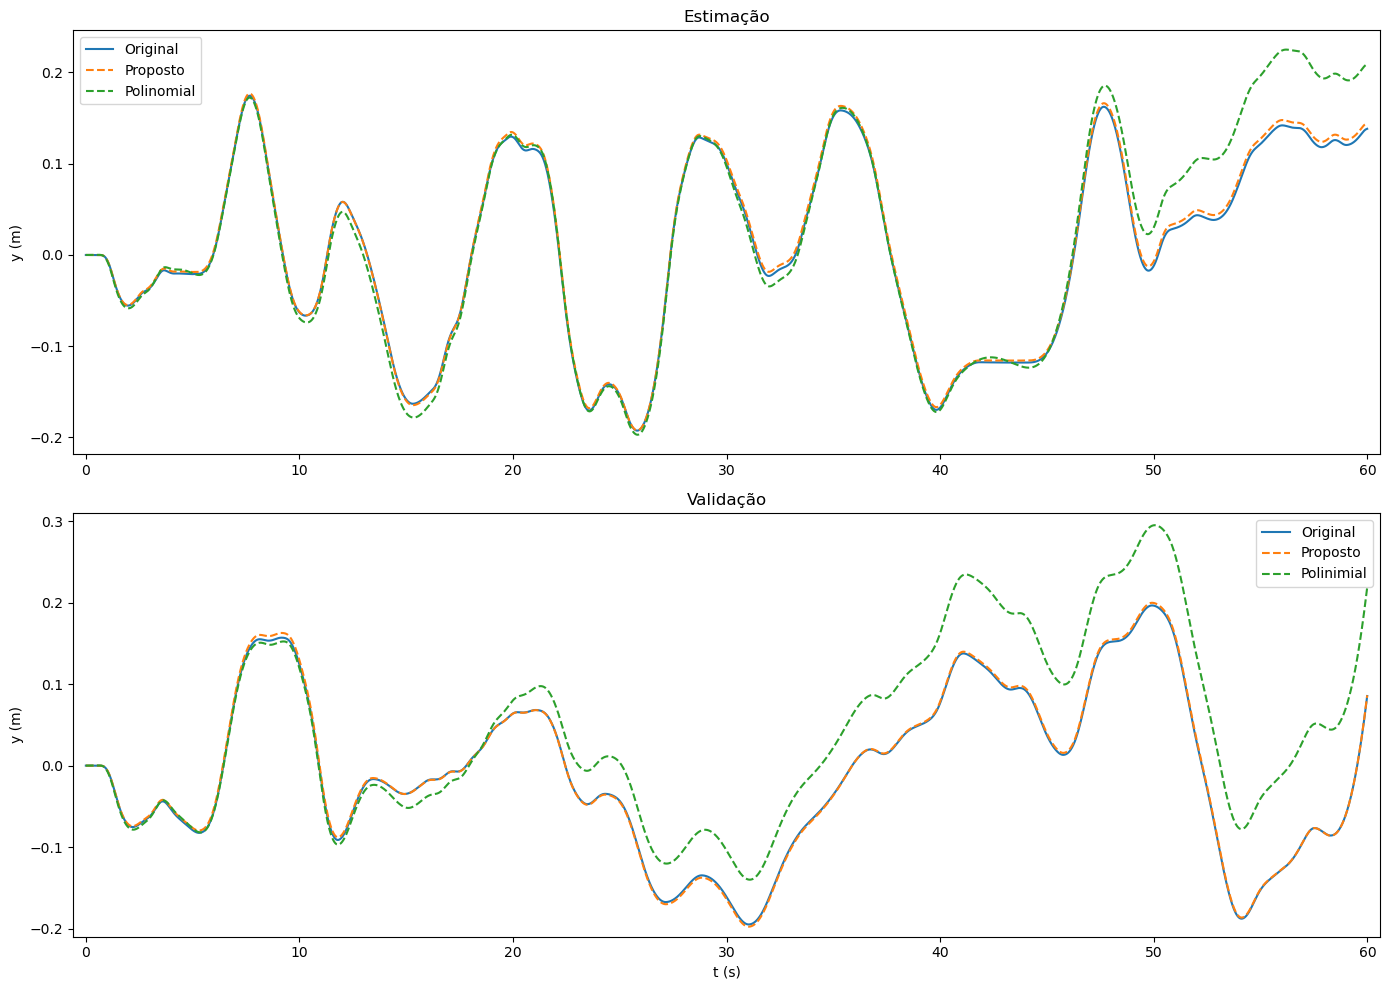

In [24]:
p = np.arange(0, 10, 0.02)

f, ax = plt.subplots(2, 1, figsize=[14, 10])
ax[0].plot(t, y, label='Original')
ax[0].plot(t, integrate(slivre, dt), '--', label='Proposto')
ax[0].plot(t, integrate(polinomial_slivre, dt), '--', label='Polinomial')

ax[0].set_ylabel('y (m)')

ax[0].set_title("Estimação")
ax[0].legend()

ax[1].plot(t, yVal.T, label='Original')
ax[1].plot(t, integrate(valLivre, dt), '--', label='Proposto')
ax[1].plot(t, integrate(polinomial_valLivre, dt), '--', label='Polinimial')
ax[1].set_ylabel('y (m)')
ax[1].set_xlabel('t (s)')
ax[1].set_ylim(-0.21, 0.31)
ax[1].set_title("Validação")
ax[1].legend()

ax[0].margins(x=0.01)
ax[1].margins(x=0.01)

plt.tight_layout() 
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Jonh - TCC/figuras/ballBeamI.png')

plt.show()